Task 1

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import norm

In [45]:
df = pd.read_csv('Telekom.csv')
df

,Date,Close
0,2014-06-17,12.585000
1,2014-06-18,12.660000
2,2014-06-19,12.800000
3,2014-06-20,12.735000
4,2014-06-23,12.675000
...,...,...
2536,2024-06-10,22.610001
2537,2024-06-11,22.610001
2538,2024-06-12,22.540001
2539,2024-06-13,22.530001


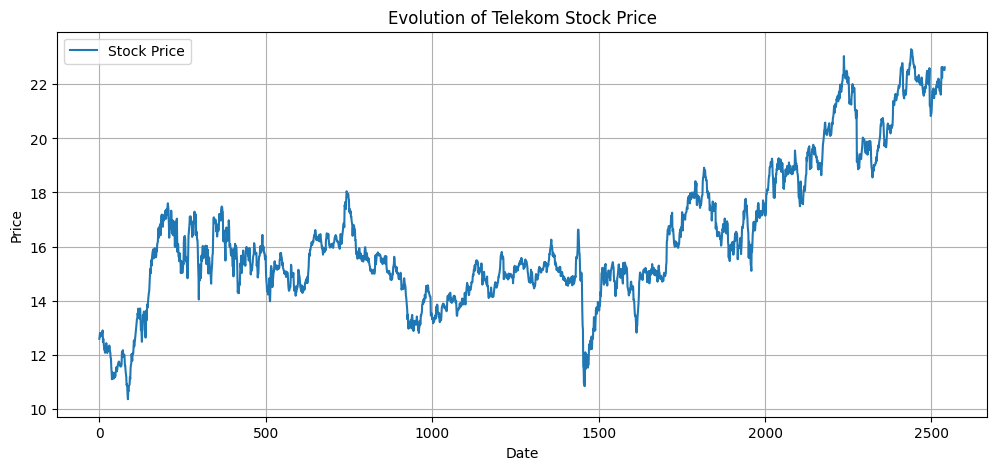

In [46]:
# Plot the stock price evolution
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Stock Price')
plt.title('Evolution of Telekom Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
df['Close'].describe()

count    2541.000000
mean       16.282396
std         2.591770
min        10.350000
25%        14.766000
50%        15.640000
75%        17.480000
max        23.299999
Name: Close, dtype: float64

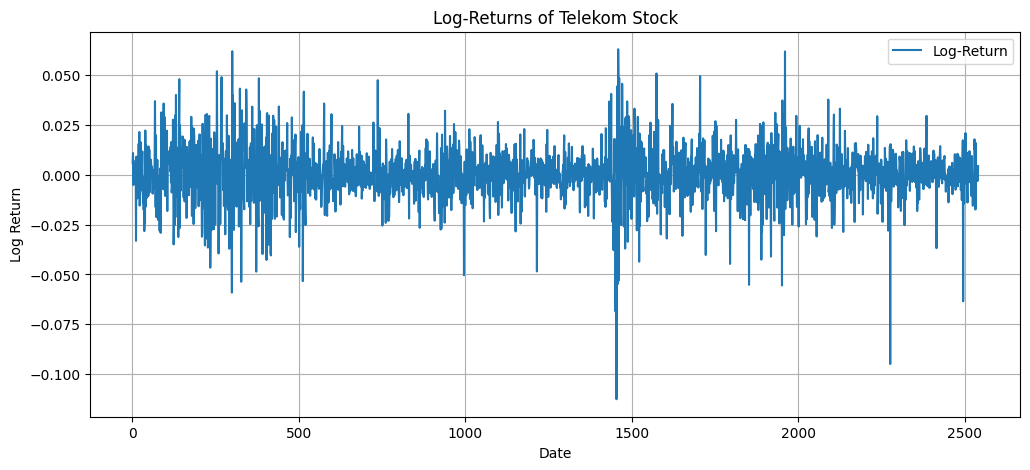

In [48]:

# Calculate log-returns
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

# Plot the log-returns
plt.figure(figsize=(12, 5))
plt.plot(df['LogReturn'], label='Log-Return')
plt.title('Log-Returns of Telekom Stock')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
df['LogReturn'].describe()

count    2540.000000
mean        0.000231
std         0.013379
min        -0.112673
25%        -0.005909
50%         0.000000
75%         0.007092
max         0.063141
Name: LogReturn, dtype: float64

Task 2

In [50]:
# Estimate annualized drift (μ) and volatility (σ)
log_returns = df['LogReturn']

dt = 1/252  # daily data, ~252 trading days per year
mu_daily = log_returns.mean()
sigma_daily = log_returns.std()

mu_annual = mu_daily / dt
sigma_annual = sigma_daily / np.sqrt(dt)

print(f"Estimated daily drift (μ): {mu_daily:.6f}")
print(f"Estimated daily volatility (σ): {sigma_daily:.6f}")
print(f"Estimated annual drift (μ): {mu_annual:.4f}")
print(f"Estimated annual volatility (σ): {sigma_annual:.4f}")

Estimated daily drift (μ): 0.000231
Estimated daily volatility (σ): 0.013379
Estimated annual drift (μ): 0.0582
Estimated annual volatility (σ): 0.2124


Task 4

Classic Bonus Certificate (Without Cap)

Long Position in Underlying Asset
Long Down-and-Out Put Option

S0 = Current Stock Price
B = K (Bonus Threshold = Strike of Put)
T = Time to Maturity
r = 2% p.a.
sigma = 0.2124

Bonus Certificate With Cap
Long Position in Underlying Asset
Long Down-and-Out Put Option
Short 1 Call at Cap

S0 = Current Stock Price
B = K (Bonus Threshold = Strike of Put)
T = Time to Maturity
r = 2% p.a.
sigma = 0.2124

Task 5

In [53]:
def bs_value(S, K, r, q, T, vol, option_type):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    if option_type.lower() == 'call':
        value = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        value = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return value

def eur_barrier_value(Fwd, S, K, H, r, q, b, trade_date, maturity_date, vol, option_type, barrier_dir, knockout_ind, dcc):
    T_vol = (maturity_date - trade_date).days / dcc
    T_r = T_vol
    r_compound = np.exp(r) - 1
    BSValue = bs_value(S, K, r_compound, q, T_vol, vol, option_type)

    DF_r = np.exp(-r * T_r)
    alpha = b / (vol**2) - 0.5
    beta = np.sqrt(alpha**2 + (2 * r) / (vol**2))
    x1 = (np.log(Fwd / K) + (vol**2) / 2 * T_vol) / (vol * np.sqrt(T_vol))
    x2 = (np.log(Fwd / H) + (vol**2) / 2 * T_vol) / (vol * np.sqrt(T_vol))
    y1 = (np.log((H * H) / (K * S)) + b * T_r + (vol**2) / 2 * T_vol) / (vol * np.sqrt(T_vol))
    y2 = (np.log(H / S) + b * T_r + (vol**2) / 2 * T_vol) / (vol * np.sqrt(T_vol))
    z = (np.log(H / S)) / (vol * np.sqrt(T_vol)) + beta * vol * np.sqrt(T_vol)

    if option_type.lower() == "call":
        phi = 1
    else:
        phi = -1

    if barrier_dir.lower() == "up":
        xi = -1
    elif barrier_dir.lower() == "down":
        xi = 1

    b1 = DF_r * phi * (Fwd * norm.cdf(phi * x1) - K * norm.cdf(phi * (x1 - vol * np.sqrt(T_vol))))
    b2 = DF_r * phi * (Fwd * norm.cdf(phi * x2) - K * norm.cdf(phi * (x2 - vol * np.sqrt(T_vol))))
    b3 = DF_r * phi * (Fwd * ((H / S)**(2 * b / (vol**2) + 1)) * norm.cdf(xi * y1) - K * ((H / S)**(2 * b / (vol**2) - 1)) * norm.cdf(xi * (y1 - vol * np.sqrt(T_vol))))
    b4 = DF_r * phi * (Fwd * ((H / S)**(2 * b / (vol**2) + 1)) * norm.cdf(xi * y2) - K * ((H / S)**(2 * b / (vol**2) - 1)) * norm.cdf(xi * (y2 - vol * np.sqrt(T_vol))))
    b5 = K * DF_r * (norm.cdf(xi * (x2 - vol * np.sqrt(T_vol))) - (H / S)**(2 * b / (vol**2) - 1) * norm.cdf(xi * (y2 - vol * np.sqrt(T_vol))))
    b6 = K * (((H / S)**(alpha + beta)) * norm.cdf(xi * z) - ((H / S)**(alpha - beta)) * norm.cdf(xi * (z - 2 * beta * vol * np.sqrt(T_vol))))

    if option_type.lower() == 'call':
        if barrier_dir.lower() == 'down':
            if S > H:
                if K > H:
                    BarrierOutValue = b1 - b3
                else:
                    BarrierOutValue = b2 - b4
            else:
                BarrierOutValue = 0
        elif barrier_dir.lower() == 'up':
            if S < H:
                if K < H:
                    BarrierOutValue = b1 - b2 + b3 - b4
                else:
                    BarrierOutValue = 0
            else:
                BarrierOutValue = 0
    else:  # Put option
        if barrier_dir.lower() == 'down':
            if S > H:
                if K > H:
                    BarrierOutValue = b1 - b2 + b3 - b4
                else:
                    BarrierOutValue = 0
            else:
                BarrierOutValue = 0
        elif barrier_dir.lower() == 'up':
            if S < H:
                if K < H:
                    BarrierOutValue = b1 - b3
                else:
                    BarrierOutValue = b2 - b4
            else:
                BarrierOutValue = 0

    if knockout_ind.lower() == 'true':
        return BarrierOutValue
    else:
        return BSValue - BarrierOutValue

# Example usage
trade_date = datetime.datetime(2023, 1, 1)
maturity_date = datetime.datetime(2024, 1, 1)
result = eur_barrier_value(df[df['Date'] == '2024-06-14'].iloc[-1]['Close'], df[df['Date'] == '2024-06-14'].iloc[-1]['Close'], 24, 16, 0.02, 0, 0, trade_date, maturity_date, 0.2124, 'put', 'down', 'true', 365)
print(f"The barrier option value is: {result:.2f}")
print(f"The Classic Bonus Certificate Value is: {result + S:.2f}")



The barrier option value is: 1.72
The Classic Bonus Certificate Value is: 24.35


Task 6

In [139]:
def monte_carlo_bonus_cert_classic(S0, H, K, T, r, sigma, n_paths=100_000, n_steps=252):
    np.random.seed()
    dt = T / n_steps
    discount_factor = np.exp(-r * T)

    # Simulate log-normal paths
    Z = np.random.randn(n_paths, n_steps)
    increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    log_paths = np.cumsum(increments, axis=1)
    log_paths = np.hstack([np.zeros((n_paths, 1)), log_paths])  # Start from S0
    S_paths = S0 * np.exp(log_paths)

    # Final price and barrier breach
    S_T = S_paths[:, -1]
    min_S = np.min(S_paths, axis=1)
    barrier_breached = min_S <= H

    # Payoff of bonus cert: S_T always + extra from down-and-out put if not breached
    put_payoff = np.where(barrier_breached, 0, np.maximum(K - S_T, 0))
    bonus_cert_payoff = S_T + put_payoff

    # Discounted expected value
    price = discount_factor * np.mean(bonus_cert_payoff)
    se = discount_factor * np.std(bonus_cert_payoff) / np.sqrt(n_paths)

    return price, se

# Parameters
S0 = df[df['Date'] == '2024-06-14'].iloc[-1]['Close']         # Current price
K = 24          # Bonus level (used in down-and-out put)
H = 16          # Barrier level
T = 1           # Maturity in years
r = 0.02        # Risk-free rate
sigma = 0.2124    # Volatility

price, se = monte_carlo_bonus_cert_classic(S0, H, K, T, r, sigma)
print(f"Bonus certificate price (Monte Carlo): {price:.4f} ± {se:.4f}")



Bonus certificate price (Monte Carlo): 24.3032 ± 0.0129


Task 7

In [54]:
import numpy as np
from scipy.stats import skew, kurtosis

# Parameters
S0 = 100
mu = 0.07
sigma = 0.2
T = 1
K = 110         # Bonus level
B = 80          # Barrier level
n_paths = 100000
np.random.seed(0)

# Simulate terminal underlying price
Z = np.random.randn(n_paths)
ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Assume price path is minimum just ST and S0 (simplified)
barrier_breached = np.minimum(S0, ST) < B

# Bonus certificate payoff
payoff = np.where(barrier_breached, ST, np.maximum(ST, K))

# Compute statistics
def stats(x):
    return {
        'mean': np.mean(x),
        'variance': np.var(x),
        'skewness': skew(x),
        'kurtosis': kurtosis(x),
        '5% quantile (VaR)': np.percentile(x, 5)
    }

underlying_stats = stats(ST)
payoff_stats = stats(payoff)


In [55]:
print(underlying_stats)
print(payoff_stats)

{'mean': 107.27225917773228, 'variance': 466.60227859138297, 'skewness': 0.612071737616847, 'kurtosis': 0.6974507474669425, '5% quantile (VaR)': 75.70381854533403}
{'mean': 114.17924234363504, 'variance': 327.94801349975825, 'skewness': 0.14918272071247335, 'kurtosis': 3.0071129944203756, '5% quantile (VaR)': 75.70381854533403}
